### ZADANIE 1.

Poniżej podany jest zestaw danych. Zawiera on brakujące wartości. 
Twoim zadaniem jest przygotować ten zestaw danych do obróbki, a następnie wytrenować klasyfikator przewidujący choroby serca dobierając ilość kroków oraz learning rate za pomocą modelu xgboost.

Wartością docelową jest num

Celem jest:
1. Oczyszczenie zbioru z kolumn pustych
2. Uzupełnienie danych tam, gdzie to konieczne
(W przypadku punktu 1. i 2. zoptymalizują proces oczyszczania,, aby zachować sens, jak i liczebność zbioru)
3. Zaproponuj metodę testowania modeli, aby zredukować problem overfittingu (możliwe jest cross-validation). Przeprowadź proces optymalizacji.
4. Wytrenuj ostateczny model

Zbiór danych: heart.csv

# 1. Importy

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


# 2. Zrozumienie danych 

In [32]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  294 non-null    object 
 4   chol      294 non-null    object 
 5   fbs       294 non-null    object 
 6   restecg   294 non-null    object 
 7   thalach   294 non-null    object 
 8   exang     294 non-null    object 
 9   oldpeak   294 non-null    float64
 10  slope     294 non-null    object 
 11  ca        294 non-null    object 
 12  thal      294 non-null    object 
 13  num       294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


In [33]:
df.replace('?', pd.NA, inplace=True)

SŁOWNIK 
- cp: Chest pain type
- trestbps: Resting blood pressure (in mm Hg on admission to the hospital)
- chol: Serum cholesterol level (in mg/dl)
- fbs: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- restecg: Resting electrocardiographic results
- thalach: Maximum heart rate achieved
- exang: Exercise-induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest
- slope: The slope of the peak exercise ST segment
- ca: Number of major vessels (0-3) colored by fluoroscopy
- thal: Thalassemia (a blood disorder) - 3 = normal; 6 = fixed defect; 7 = reversible defect

In [9]:
# ZMIANA TYPU DANYCH
# na kategoryczne: sex, cp,  
# na numeryczne: trestbps, chol, thalach

In [34]:
columns_to_numeric = ['trestbps', 'chol', 'thalach']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce', downcast='integer')

In [35]:
df['sex'] = df['sex'].astype(object)
df['cp'] = df['cp'].astype(object)

In [8]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130.0,132.0,0,2,185.0,0,0.0,<NA>,<NA>,<NA>,0
1,29,1,2,120.0,243.0,0,0,160.0,0,0.0,<NA>,<NA>,<NA>,0
2,29,1,2,140.0,NaN,0,0,170.0,0,0.0,<NA>,<NA>,<NA>,0
3,30,0,1,170.0,237.0,0,1,170.0,0,0.0,<NA>,<NA>,6,0
4,31,0,2,100.0,219.0,0,1,150.0,0,0.0,<NA>,<NA>,<NA>,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    object 
 2   cp        294 non-null    object 
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    object 
 6   restecg   293 non-null    object 
 7   thalach   293 non-null    float64
 8   exang     293 non-null    object 
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    object 
 11  ca        3 non-null      object 
 12  thal      28 non-null     object 
 13  num       294 non-null    int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 32.3+ KB


In [9]:
df.describe()

,age,trestbps,chol,thalach,oldpeak,num
count,294.000000,293.000000,271.000000,293.000000,294.000000,294.000000
mean,47.826531,132.583618,250.848708,139.129693,0.586054,0.360544
std,7.811812,17.626568,67.657711,23.589749,0.908648,0.480977
min,28.000000,92.000000,85.000000,82.000000,0.000000,0.000000
25%,42.000000,120.000000,209.000000,122.000000,0.000000,0.000000
50%,49.000000,130.000000,243.000000,140.000000,0.000000,0.000000
75%,54.000000,140.000000,282.500000,155.000000,1.000000,1.000000
max,66.000000,200.000000,603.000000,190.000000,5.000000,1.000000


In [10]:
df.shape

(294, 14)

In [11]:
unique_sizes = df.nunique()
print(unique_sizes)

age          38
sex           2
cp            4
trestbps     31
chol        153
fbs           2
restecg       3
thalach      71
exang         2
oldpeak      10
slope         3
ca            1
thal          3
num           2
dtype: int64


In [12]:
df.isnull().sum()

age           0
sex           0
cp            0
trestbps      1
chol         23
fbs           8
restecg       1
thalach       1
exang         1
oldpeak       0
slope       190
ca          291
thal        266
num           0
dtype: int64

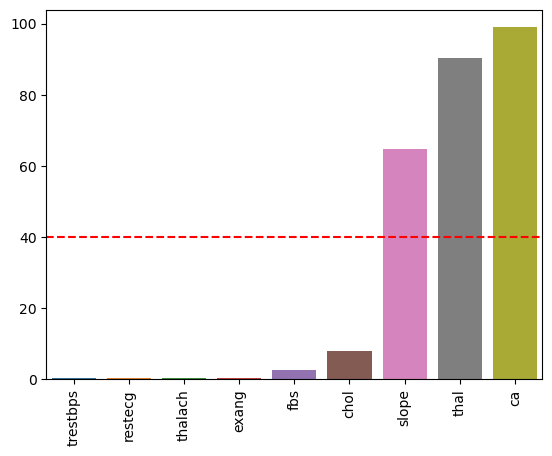

In [13]:
def percent_missing(df):
    percent_nan = 100* df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan>0].sort_values()
    return percent_nan
percent_nan = percent_missing(df)

sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);

# Punkt odcięcia 40%
plt.axhline(y=40, color='r', linestyle='--')

plt.show()

# 3. Przygotowanie danych

In [14]:
df['fbs'].value_counts()

0    266
1     20
Name: fbs, dtype: int64

In [36]:
# Większość wierszy ma 0 w kolumnie fbs, zastąpie brakujące wiersze liczbą 0
df['fbs'] = df['fbs'].fillna(0).astype(int)
df['fbs'].value_counts()

0    274
1     20
Name: fbs, dtype: int64

Trzy kategorie, które mają ponad 40% brakujących wierszy ('slope', 'thal', 'ca').
Nie widzę sposobu na uzupełnienie ich. Usunę te 3 kolumny.

In [16]:
df['slope'].value_counts()

2    91
1    12
3     1
Name: slope, dtype: int64

In [17]:
df['thal'].value_counts()

7    11
6    10
3     7
Name: thal, dtype: int64

In [18]:
df['ca'].value_counts()

0    3
Name: ca, dtype: int64

In [37]:
# Oczyszczenie zbioru z kolumn gdzie brakuje >40% wierszy?
df = df.drop(['slope', 'ca', 'thal'], axis=1)

In [20]:
df['trestbps'].value_counts()

120.0    65
130.0    54
140.0    50
150.0    23
110.0    21
160.0    20
125.0     8
100.0     6
180.0     6
135.0     5
145.0     5
170.0     5
112.0     3
115.0     2
124.0     2
118.0     2
122.0     2
92.0      1
138.0     1
136.0     1
128.0     1
200.0     1
106.0     1
142.0     1
113.0     1
108.0     1
132.0     1
190.0     1
98.0      1
105.0     1
155.0     1
Name: trestbps, dtype: int64

In [38]:
# jeden wiersz to 0,003% bazy danych więc usuwam ten wiersz
df.dropna(subset=['trestbps'], inplace=True)
df.dropna(subset=['restecg'], inplace=True)

In [22]:
df['restecg'].value_counts()

0    235
1     51
2      6
Name: restecg, dtype: int64

In [23]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'num'],
      dtype='object')

In [39]:
#brakujące wiersze w kolumnie chol, zostały wypełnione średnią wartością
mean_chol = df['chol'].mean()
df['chol'] = df['chol'].fillna(mean_chol)

In [25]:
df.corr()

,age,trestbps,chol,fbs,thalach,oldpeak,num
age,1.000000,0.244305,0.085141,0.182142,-0.459680,0.180738,0.156045
trestbps,0.244305,1.000000,0.079677,0.097590,-0.184831,0.207985,0.138260
chol,0.085141,0.079677,1.000000,0.109439,-0.121795,0.104378,0.202901
fbs,0.182142,0.097590,0.109439,1.000000,-0.070586,0.064898,0.164101
thalach,-0.459680,-0.184831,-0.121795,-0.070586,1.000000,-0.303544,-0.331802
oldpeak,0.180738,0.207985,0.104378,0.064898,-0.303544,1.000000,0.557522
num,0.156045,0.138260,0.202901,0.164101,-0.331802,0.557522,1.000000


# Wizualizacja

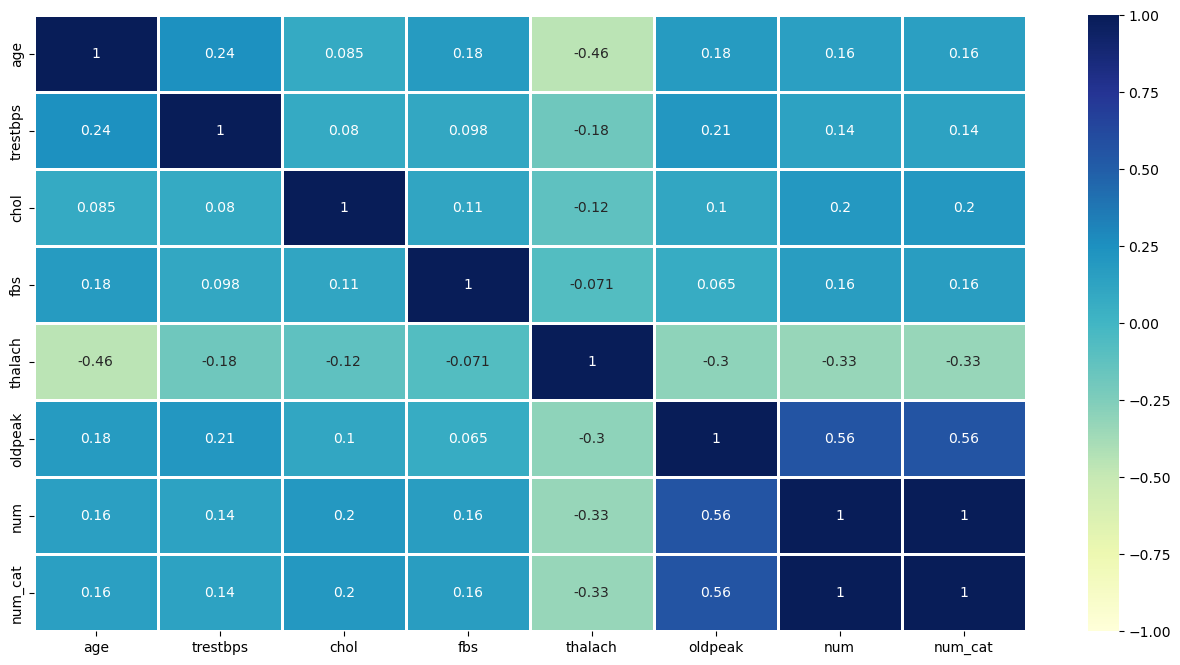

In [26]:
# sprawdzenie korelacji
df['num_cat'] = (df['num'] != 0).astype('int8')

plt.rcParams['figure.figsize']=(16,8)
sns.heatmap(df.corr(method='pearson',), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

<AxesSubplot:xlabel='num', ylabel='count'>

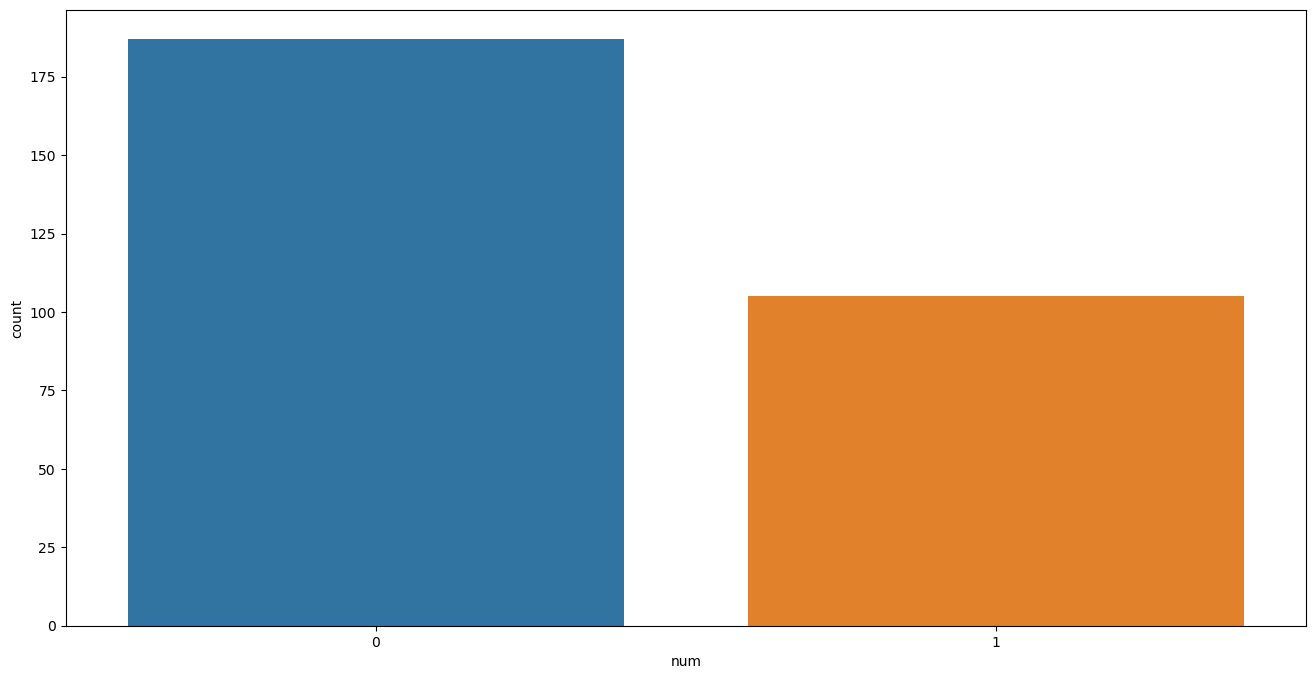

In [27]:
sns.countplot(data=df,x='num')

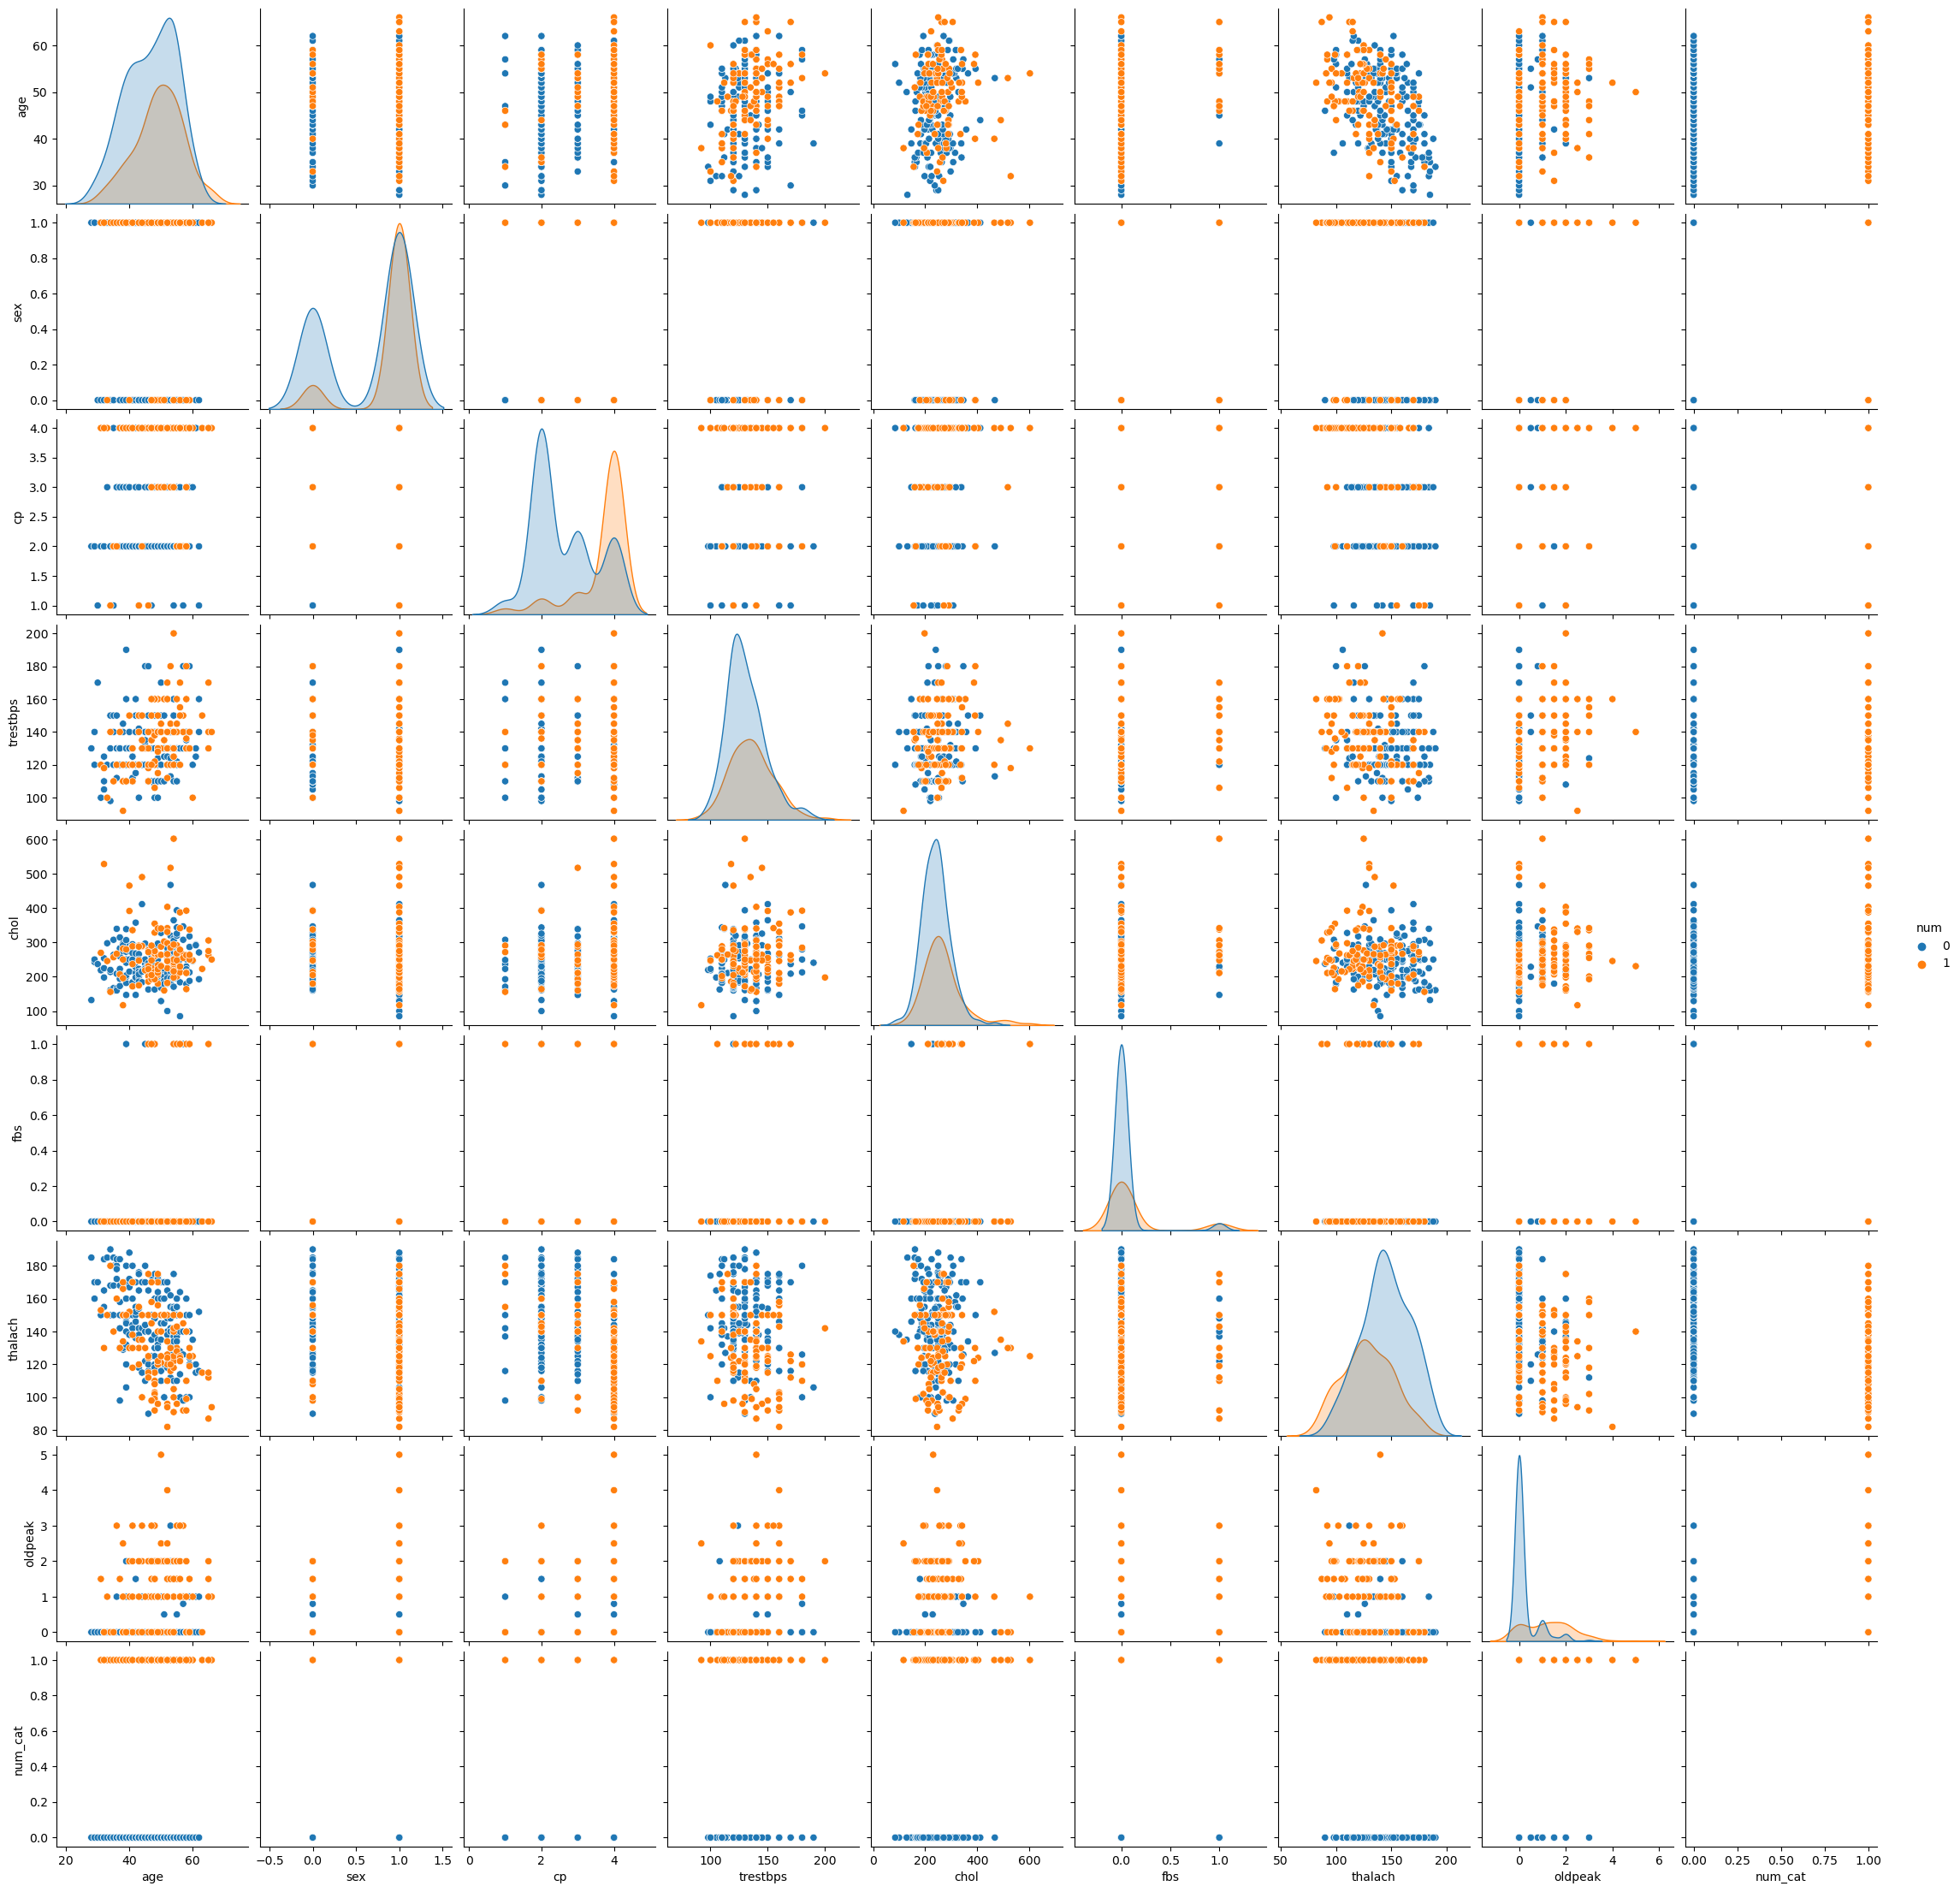

In [28]:
sns.pairplot(df,hue='num')

In [40]:
df.to_csv("heart_NO_Missing_Data.csv",index=False)